In [4]:
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
#from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

## READING DATA

In [5]:
data_dir = '../input/lgg-mri-segmentation/kaggle_3m/'
images_paths = []
masks_paths = glob(f'{data_dir}/*/*_mask*')

for i in masks_paths:
    images_paths.append(i.replace('_mask', ''))

df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})
images_paths = []
masks_paths = glob(f'{data_dir}/*/*_mask*')

for i in masks_paths:
    images_paths.append(i.replace('_mask', ''))

df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

## Positive negative divisions

In [6]:
def pos_neg_diagnosis(masks_paths):
    value = np.max(cv2.imread(masks_paths))
    if value > 0 : 
        return 1
    else:
        return 0
df['mask'] = df['masks_paths'].apply(lambda x: pos_neg_diagnosis(x))
df

images_paths  \
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
...                                                 ...   
3924  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3925  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3926  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3927  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3928  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                            masks_paths  mask  
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
...                                                 ...   ...  
3924  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
3925  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
3926  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
3927  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
3928  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  

[3929 rows x 3 columns]

In [7]:
df['mask'].value_counts()


mask
0    2556
1    1373
Name: count, dtype: int64

In [8]:
brain_df_mask = df[df['mask'] == 1]
brain_df_mask.shape

(1373, 3)

## Train, Test, Dummy Split

In [9]:
 train_df, dummy_df = train_test_split(brain_df_mask, train_size= 0.8)

valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)


In [10]:
train_df

images_paths  \
900   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3714  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3693  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
2837  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3557  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
...                                                 ...   
2497  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
1643  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
2503  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
1884  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1062  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                            masks_paths  mask  
900   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...     1  
3714  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
3693  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...     1  
2837  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
3557  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
...                                                 ...   ...  
2497  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...     1  
1643  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1  
2503  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...     1  
1884  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
1062  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  

[1098 rows x 3 columns]

## Error Handling for images

In [11]:
tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

## Image Generator

In [12]:
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40


    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

In [13]:
train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

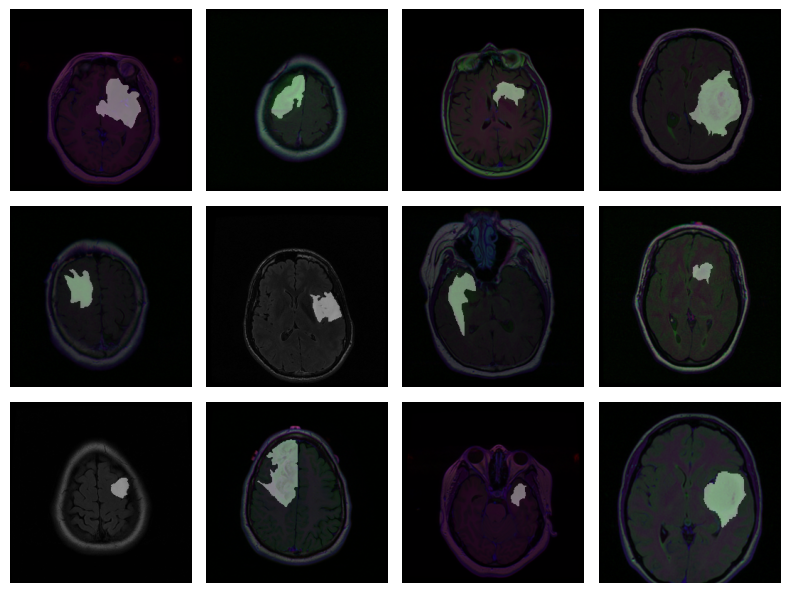

In [14]:
images=list(train_df['images_paths'])
masks=list(train_df['masks_paths'])
plt.figure(figsize=(8, 8))
for i in range(12):
    plt.subplot(4, 4, i+1)
    img_path = images[i]
    mask_path = masks[i]
        # read image and convert it to RGB scale
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    #mask[mask==255] = (255,0,0)
        # sho image and mask
    plt.imshow(image)
    plt.imshow(mask, alpha=.4)

    plt.axis('off')

plt.tight_layout()
plt.show()


## U-NET Model



In [15]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu')(inputs)
    conv11 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu')(conv1)
    bn1 = BatchNormalization(axis=3)(conv11)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu')(pool1)
    conv22 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu')(conv2)
    bn2 = BatchNormalization(axis=3)(conv22)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu')(pool2)
    conv33 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu')(conv3)
    bn3 = BatchNormalization(axis=3)(conv33)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu')(pool3)
    conv44 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu')(conv4)
    bn4 = BatchNormalization(axis=3)(conv44)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same", activation='relu')(pool4)
    conv55 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same", activation='relu')(conv5)
    bn5 = BatchNormalization(axis=3)(conv55)
    bn5 = Activation("relu")(bn5)
    # Decoder


    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu')(up6)
    conv66 = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu')(conv6)
    bn6 = BatchNormalization(axis=3)(conv66)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu')(up7)
    conv77 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu')(conv7)
    bn7 = BatchNormalization(axis=3)(conv77)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu')(up8)
    conv88 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu')(conv8)
    bn8 = BatchNormalization(axis=3)(conv88)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu')(up9)
    conv99 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu')(conv9)
    bn9 = BatchNormalization(axis=3)(conv99)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

## Metrics

In [16]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

## Model

In [17]:
from tensorflow.keras.metrics import AUC 
model = unet()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss,
              metrics= ['accuracy', iou_coef, dice_coef,
                       AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False,
                                    from_logits=False)
                       ])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d_1[0][0]']            
 Normalization)                                                                               

## Training

In [18]:
epochs = 50
batch_size = 40
checkpointer = ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True,
    verbose=1)


reduce_lr =ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 6, verbose = 1)

In [19]:
result = model.fit(train_gen,
                    steps_per_epoch=len(train_df) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[checkpointer ],
                    validation_data = valid_gen,
                    validation_steps=len(valid_df) / batch_size
                   )

Found 1098 validated image filenames.
Found 1098 validated image filenames.
Epoch 1/50
28/27 [==============================] - ETA: 0s - loss: -0.1566 - accuracy: 0.8836 - iou_coef: 0.0855 - dice_coef: 0.1569 - auc: 0.9462Found 137 validated image filenames.
Found 137 validated image filenames.

Epoch 1: val_dice_coef improved from -inf to 0.13506, saving model to best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 89s 2s/step - loss: -0.1566 - accuracy: 0.8836 - iou_coef: 0.0855 - dice_coef: 0.1569 - auc: 0.9462 - val_loss: -0.1528 - val_accuracy: 0.9002 - val_iou_coef: 0.0737 - val_dice_coef: 0.1351 - val_auc: 0.8678
Epoch 2/50
28/27 [==============================] - ETA: 0s - loss: -0.1993 - accuracy: 0.9380 - iou_coef: 0.1114 - dice_coef: 0.2000 - auc: 0.9636
Epoch 2: val_dice_coef improved from 0.13506 to 0.14820, saving model to best_model.h5
27/27 [==============================] - 28s 1s/step - loss: -0.1993 - accuracy: 0.9380 - iou_coef: 0.1114 - dice_coef: 0.2000 - auc: 0.9636 - val_loss: -0.1717 - val_accuracy: 0.9748 - val_iou_coef: 0.0822 - val_dice_coef: 0.1482 - val_auc: 0.6691
Epoch 3/50
28/27 [==============================] - ETA: 0s - loss: -0.2473 - accuracy: 0.9511 - iou_coef: 0.1425 - dice_coef: 0.2479 - auc: 0.9530
Epoch 3: val_dice_coef improved from 0.14820 to 0.24728, saving model to best_model.h5
27/27 [=========================

## Result

In [20]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

results = model.evaluate(test_gen, steps= test_steps, verbose= 0)


print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("     Test IoU: {:.2f}%".format(results[2] * 100))
print("    Test Dice: {:.2f}%".format(results[3] * 100))
print("     Test AUC: {:.4f}".format(results[4]))

Found 138 validated image filenames.
Found 138 validated image filenames.
Test Accuracy: 98.31%
     Test IoU: 50.21%
    Test Dice: 66.70%
     Test AUC: 0.8386


## Image processing to know the level

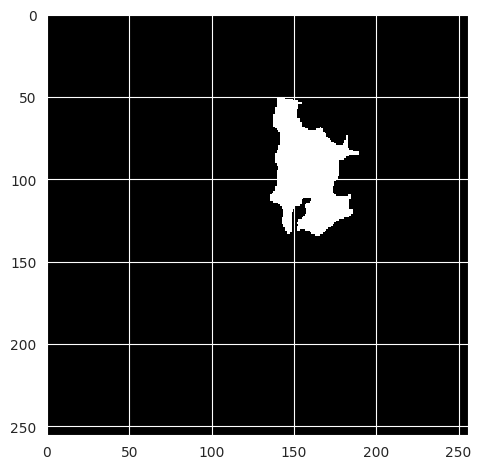

In [23]:
imshow(test_df['masks_paths'].iloc[1])

In [24]:
img=cv2.imread(test_df['masks_paths'].iloc[1])
img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [25]:


def count_pixels(image):
    grayscale_image = np.mean(image, axis=2)

    white_pixels = np.count_nonzero(grayscale_image == 255)
    black_pixels = np.count_nonzero(grayscale_image == 0)

    return white_pixels, black_pixels

white, black = count_pixels(img)
print("Number of white pixels:", white)
print("Number of black pixels:", black)


Number of white pixels: 2516
Number of black pixels: 63020


In [26]:
per=(white/black)*100
print("percentage of brain affected",per)

percentage of brain affected 3.992383370358616


## Unet++

In [27]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, LeakyReLU, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

def conv_block(inputs, filters, kernel_size=(3, 3), padding='same'):
    conv1 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding)(inputs)
    bn1 = BatchNormalization(axis=3)(conv1)
    act1 = LeakyReLU(alpha=0.2)(bn1)
    
    conv2 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding)(act1)
    bn2 = BatchNormalization(axis=3)(conv2)
    act2 = LeakyReLU(alpha=0.2)(bn2)
    
    return act2

def unet_plusplus(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = conv_block(inputs, filters=64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, filters=128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, filters=256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, filters=512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = conv_block(pool4, filters=1024)
    
    # Additional layers in the Encoder
    conv6 = conv_block(conv5, filters=1024)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv6)

    conv7 = conv_block(pool5, filters=2048)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv7)

    conv8 = conv_block(pool6, filters=2048)
    pool7 = MaxPooling2D(pool_size=(2, 2))(conv8)

    conv9 = conv_block(pool7, filters=4096)
    pool8 = MaxPooling2D(pool_size=(2, 2))(conv9)
    
    # Decoder
    up9 = concatenate([Conv2DTranspose(2048, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv9), conv8], axis=3)
    conv10 = conv_block(up9, filters=2048)
    
    up10 = concatenate([Conv2DTranspose(2048, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv10), conv7], axis=3)
    conv11 = conv_block(up10, filters=2048)
    
    up11 = concatenate([Conv2DTranspose(1024, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv11), conv6], axis=3)
    conv12 = conv_block(up11, filters=1024)

    up12 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv12), conv5], axis=3)
    conv13 = conv_block(up12, filters=512)

    up13 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv13), conv4], axis=3)
    conv14 = conv_block(up13, filters=256)

    crop1 = Cropping2D(cropping=((4, 4), (4, 4)))(conv3)
    up14 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv14), crop1], axis=3)
    conv15 = conv_block(up14, filters=128)

    crop2 = Cropping2D(cropping=((16, 16), (16, 16)))(conv2)
    up15 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv15), crop2], axis=3)
    conv16 = conv_block(up15, filters=64)

    crop3 = Cropping2D(cropping=((40, 40), (40, 40)))(conv1)
    up16 = concatenate([Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv16), crop3], axis=3)
    conv17 = conv_block(up16, filters=32)

    conv18 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(conv17)

    return Model(inputs=[inputs], outputs=[conv18])

# Create the extended U-Net++ model
model = unet_plusplus()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 256, 256, 64)         256       ['conv2d_19[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_9 (Activation)   (None, 256, 256, 64)         0         ['batch_normalization_9[

In [28]:
from tensorflow.keras.metrics import AUC 
model = unet_plusplus()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss,
              metrics= ['accuracy', iou_coef, dice_coef,
                       AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False,
                                    from_logits=False)
                       ])

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_27 (Ba  (None, 256, 256, 64)         256       ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_27 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_27

In [29]:
epochs = 50
batch_size = 40
checkpointer = ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True,
    verbose=1)


reduce_lr =ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 6, verbose = 1)

In [30]:
result = model.fit(train_gen,
                    steps_per_epoch=len(train_df) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[checkpointer ],
                    validation_data = valid_gen,
                    validation_steps=len(valid_df) / batch_size
                   )

Epoch 1/50
28/27 [==============================] - ETA: 0s - loss: -0.2637 - accuracy: 0.8970 - iou_coef: 0.1558 - dice_coef: 0.2652 - auc_1: 0.9266
Epoch 1: val_dice_coef improved from -inf to 0.05193, saving model to best_model.h5
27/27 [==============================] - 62s 1s/step - loss: -0.2637 - accuracy: 0.8970 - iou_coef: 0.1558 - dice_coef: 0.2652 - auc_1: 0.9266 - val_loss: -0.0528 - val_accuracy: 0.0272 - val_iou_coef: 0.0267 - val_dice_coef: 0.0519 - val_auc_1: 0.5295
Epoch 2/50
28/27 [==============================] - ETA: 0s - loss: -0.4294 - accuracy: 0.9787 - iou_coef: 0.2759 - dice_coef: 0.4302 - auc_1: 0.9486
Epoch 2: val_dice_coef improved from 0.05193 to 0.08641, saving model to best_model.h5
27/27 [==============================] - 31s 1s/step - loss: -0.4294 - accuracy: 0.9787 - iou_coef: 0.2759 - dice_coef: 0.4302 - auc_1: 0.9486 - val_loss: -0.0846 - val_accuracy: 0.5681 - val_iou_coef: 0.0452 - val_dice_coef: 0.0864 - val_auc_1: 0.8118
Epoch 3/50
28/27 [=====

In [31]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

results = model.evaluate(test_gen, steps= test_steps, verbose= 0)


print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("     Test IoU: {:.2f}%".format(results[2] * 100))
print("    Test Dice: {:.2f}%".format(results[3] * 100))
print("     Test AUC: {:.4f}".format(results[4]))

Test Accuracy: 99.39%
     Test IoU: 81.92%
    Test Dice: 90.04%
     Test AUC: 0.9569


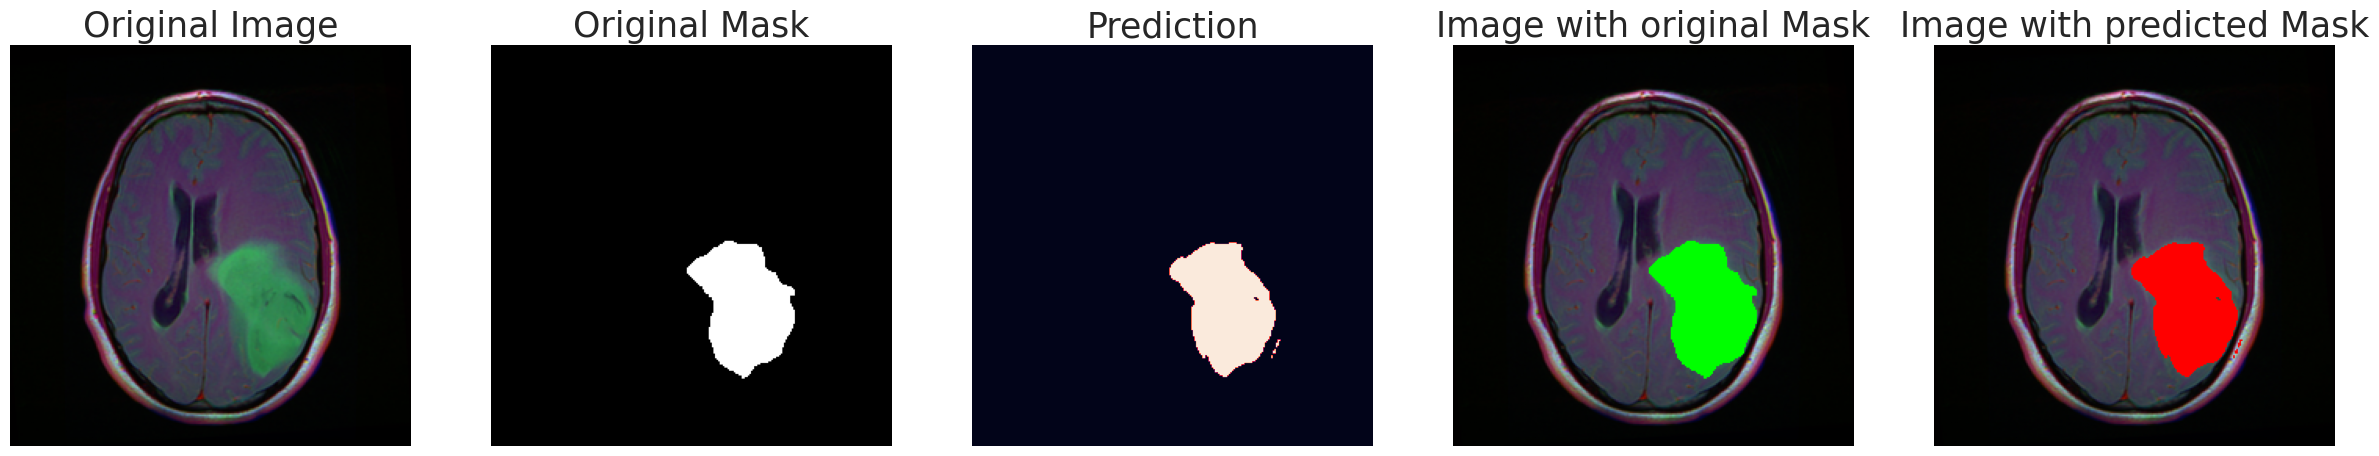

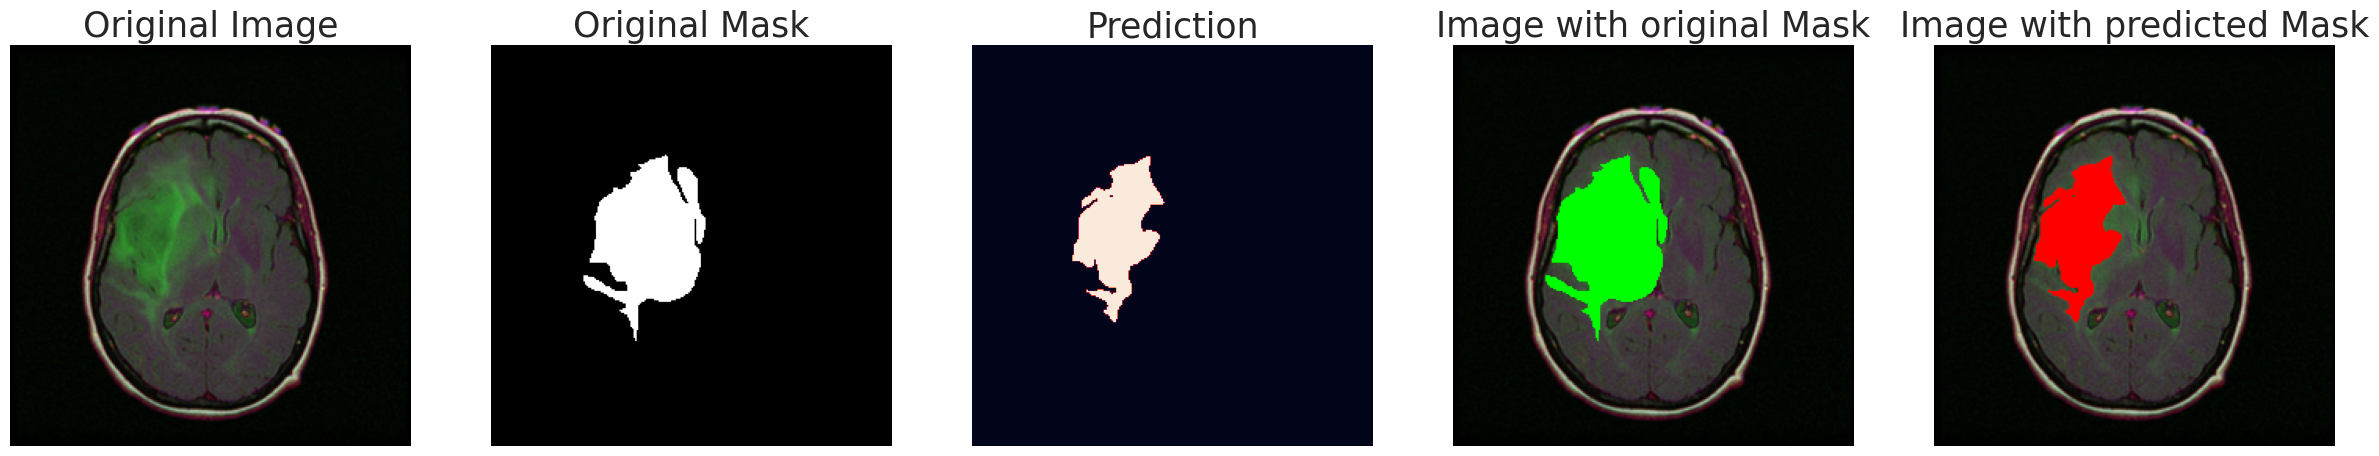

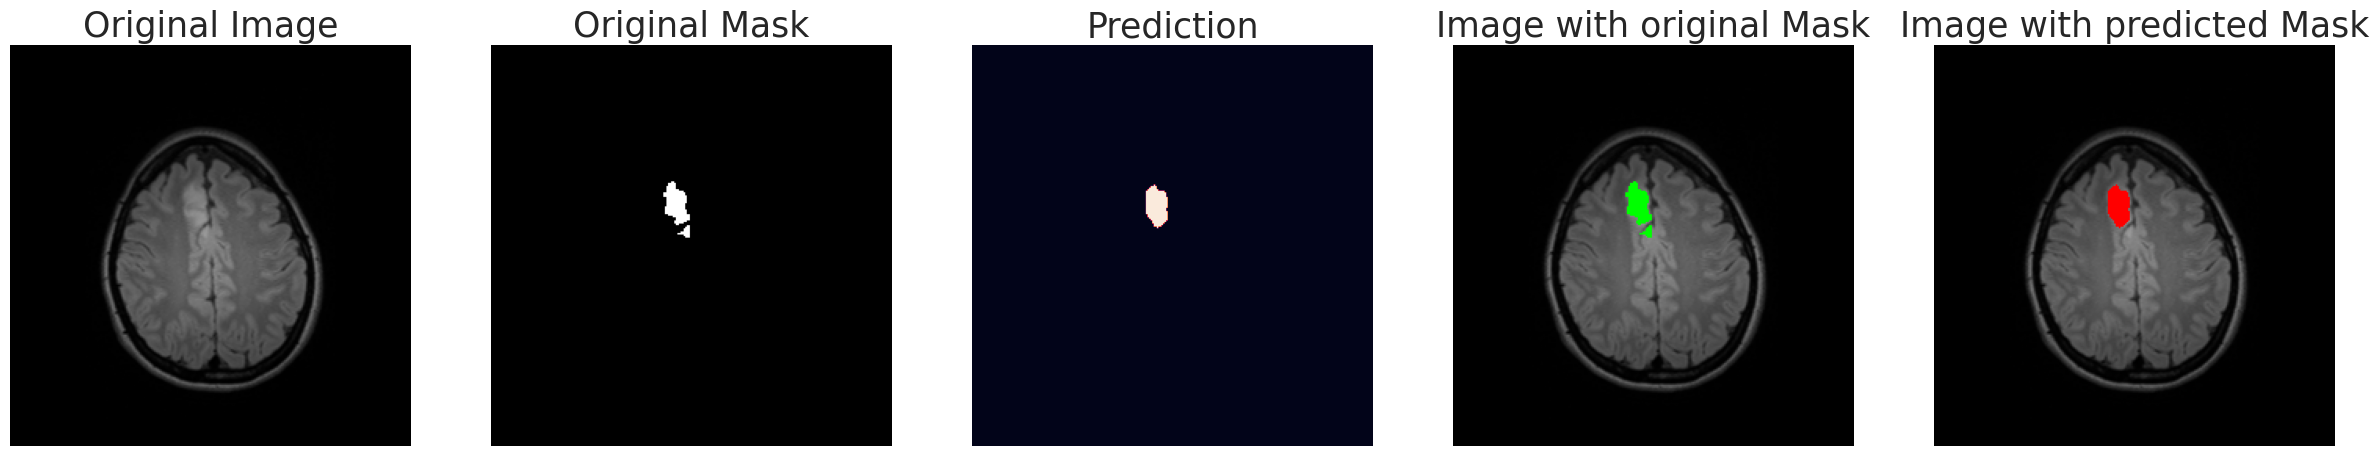

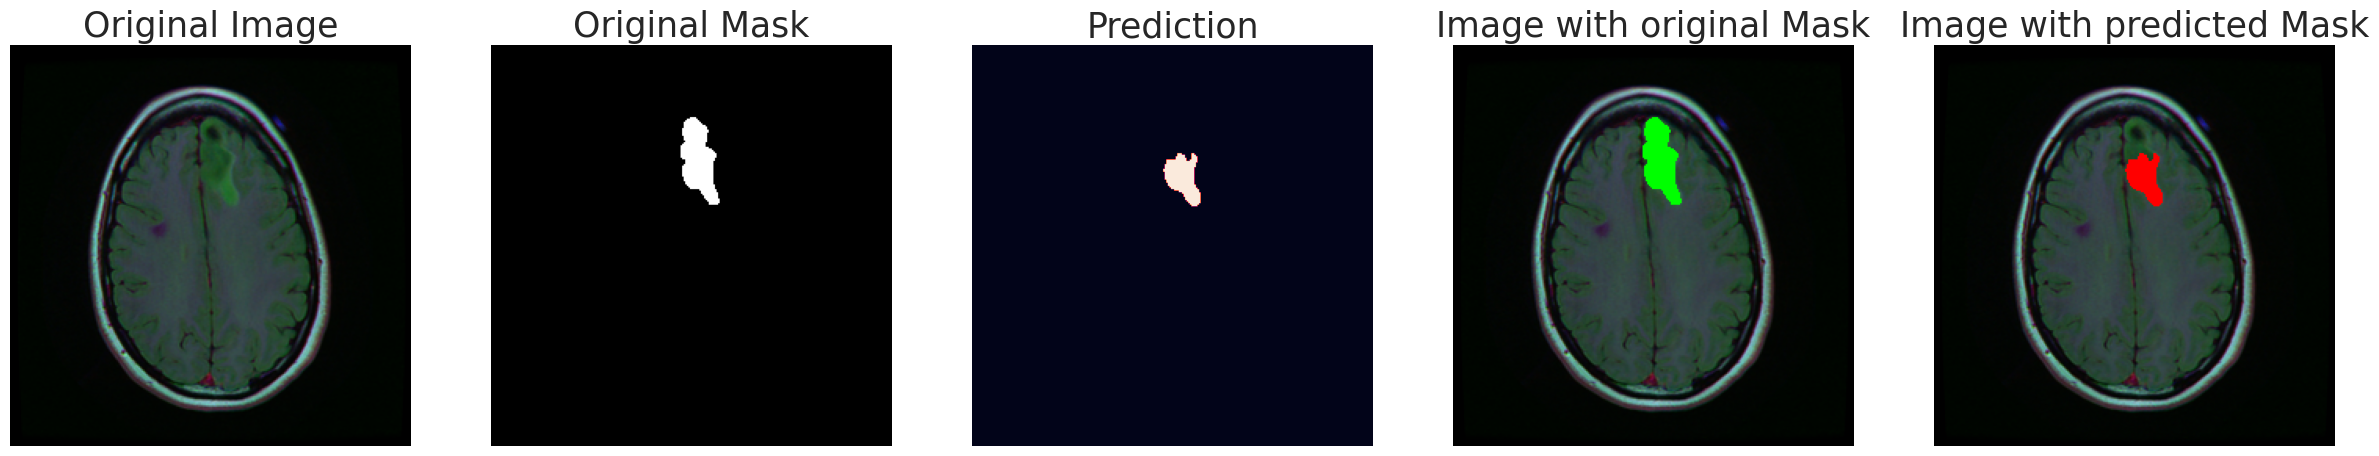

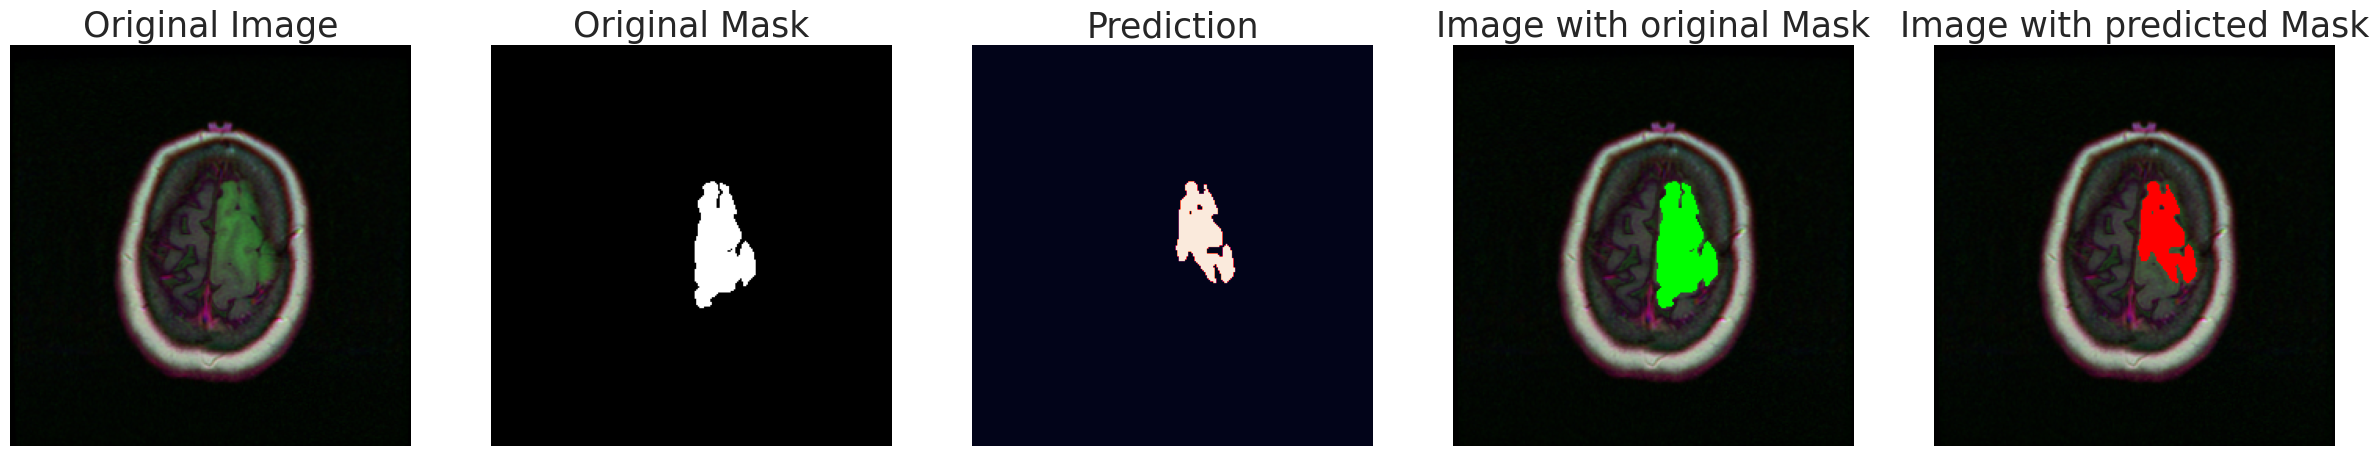

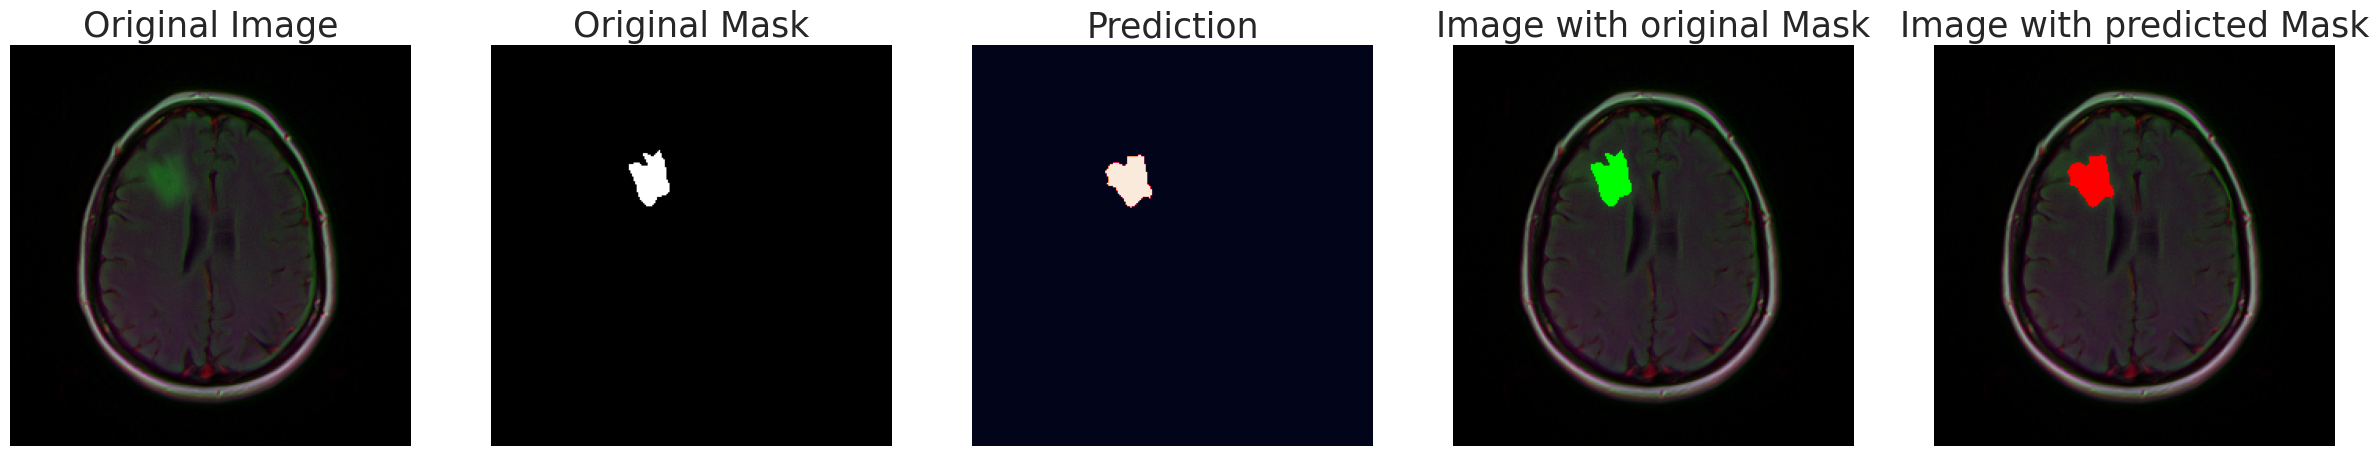

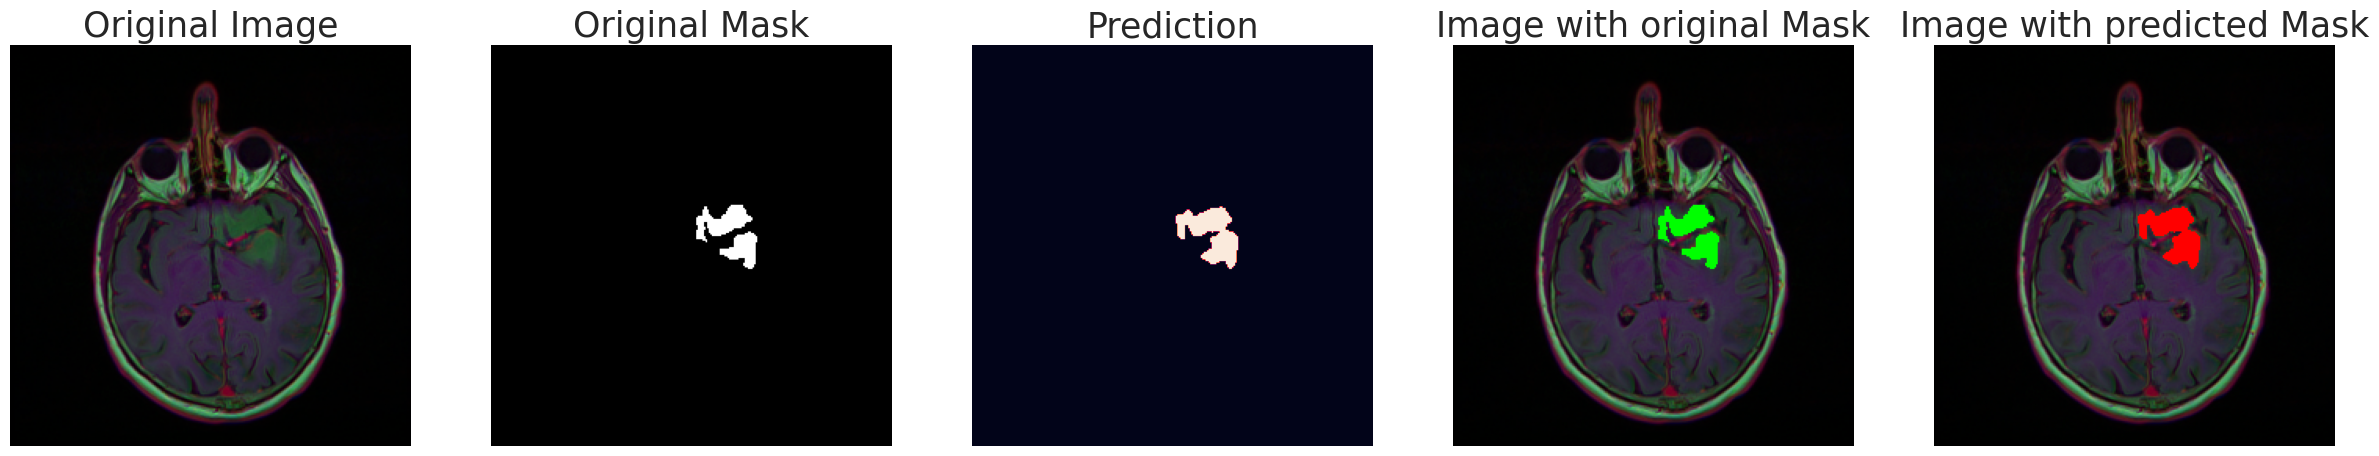

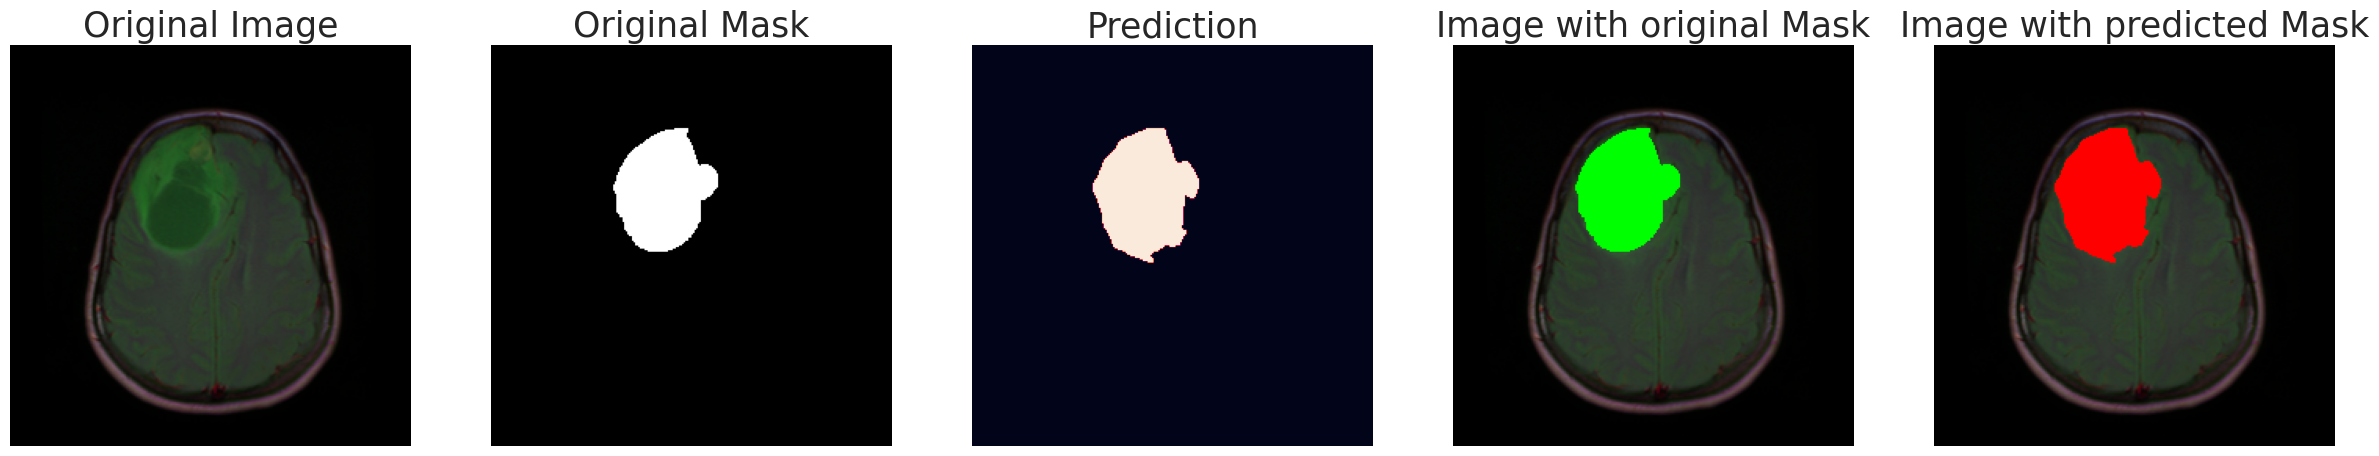

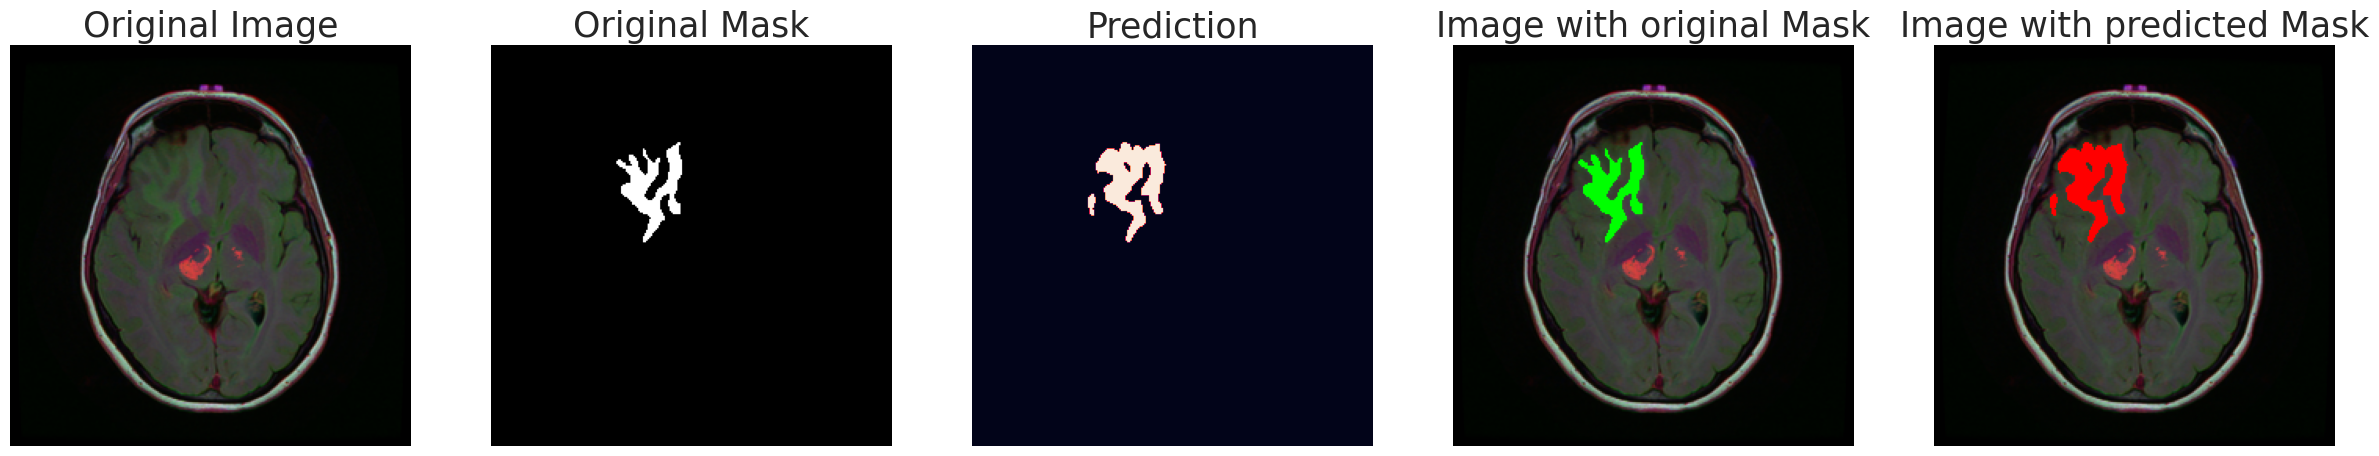

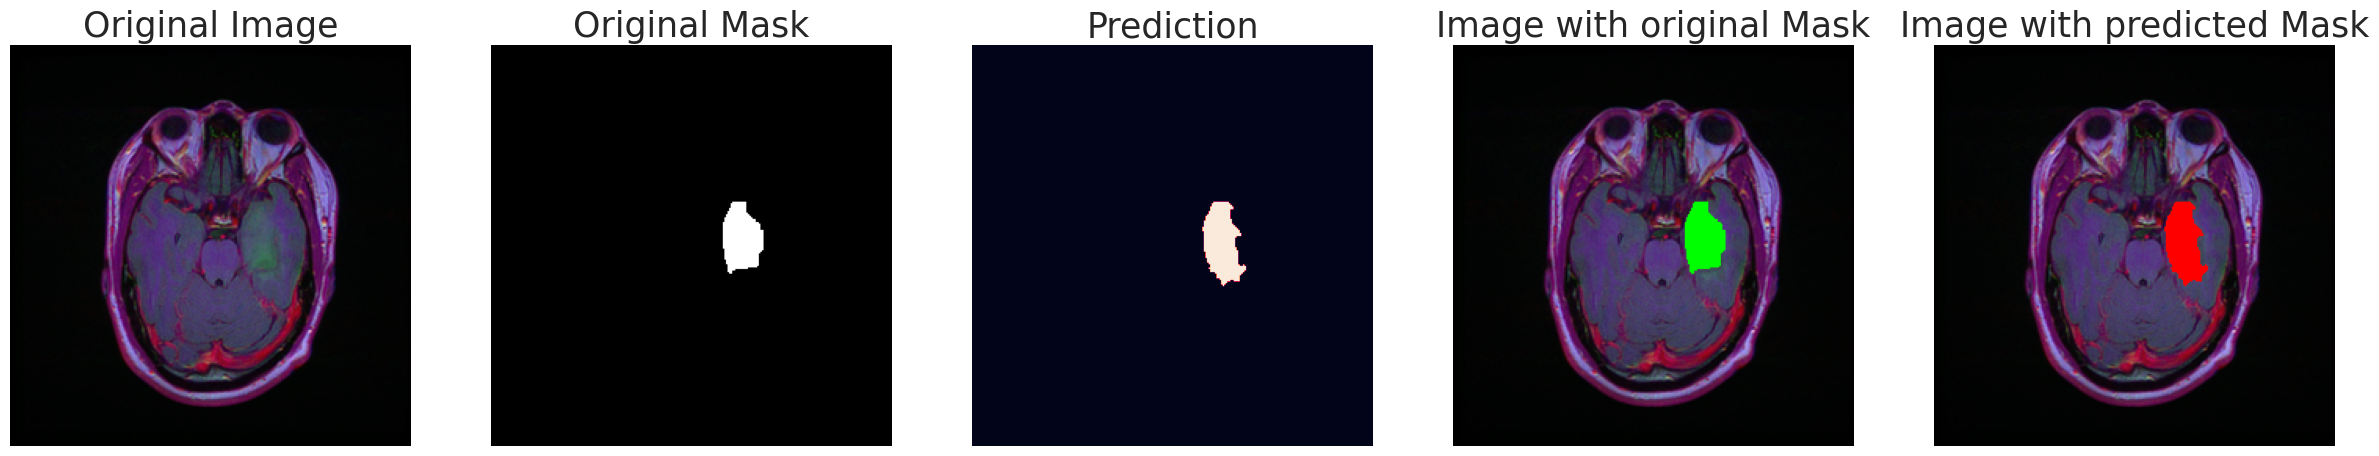

In [32]:
for _ in range(10):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img, verbose=0)

    plt.figure(figsize=(30, 70))
    
    plt.subplot(1, 5, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image',fontdict={'fontsize':25})

    plt.subplot(1, 5, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask',fontdict={'fontsize':25})

    plt.subplot(1, 5, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction',fontdict={'fontsize':25})
    plt.axis('off')
    
    img1= np.squeeze(img.copy())
    omask = cv2.imread(test_df['masks_paths'].iloc[index])
    omask = cv2.cvtColor(omask,cv2.COLOR_RGB2GRAY)
    img1[omask==255] = (0,255,0)
    plt.subplot(1, 5, 4)
    plt.imshow(img1)
    plt.title('Image with original Mask',fontdict={'fontsize':25})
    plt.axis('off')
    
    img2=np.squeeze(img.copy())
    predicted_img = np.squeeze(predicted_img)
    img2[predicted_img>0.5] = (255,0,0)    
    plt.subplot(1, 5, 5)
    plt.imshow(img2)
    plt.title('Image with predicted Mask',fontdict={'fontsize':25})
    plt.axis('off')
    
    plt.show
# plt.savefig( 'preds.jpg', dpi=800, bbox_inches = 'tight')

### Link Net


In [33]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Add

def encoder_block(inputs, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(inputs)
    bn = BatchNormalization(axis=3)(conv)
    act = Activation(activation)(bn)
    return act

def decoder_block(inputs, skip, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
    upsample = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    concat = concatenate([upsample, skip], axis=3)
    conv = Conv2D(filters, kernel_size, strides=strides, padding='same')(concat)
    bn = BatchNormalization(axis=3)(conv)
    act = Activation(activation)(bn)
    return act

def linknet(input_size=(256, 256, 3), num_classes=1):
    inputs = Input(input_size)
    
    # Encoder
    enc1 = encoder_block(inputs, 64)
    enc2 = encoder_block(enc1, 128, strides=(2, 2))
    enc3 = encoder_block(enc2, 256, strides=(2, 2))
    enc4 = encoder_block(enc3, 512, strides=(2, 2))
    
    # Decoder
    dec4 = decoder_block(enc4, enc3, 256)
    dec3 = decoder_block(dec4, enc2, 128)
    dec2 = decoder_block(dec3, enc1, 64)
    
    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(dec2)
    
    return Model(inputs=inputs, outputs=outputs)

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

model = linknet()

In [35]:
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', iou_coef, dice_coef,
                       AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False,
                                    from_logits=False)
                       ])  # Add other metrics like dice, AUC, IoU if necessary


model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 256, 256, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_45 (Ba  (None, 256, 256, 64)         256       ['conv2d_57[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_45 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_45

In [36]:
epochs = 50

history = model.fit(train_gen,
                    steps_per_epoch=len(train_df) // batch_size,
                    epochs=epochs,
                    validation_data=valid_gen,
                    validation_steps=len(valid_df) // batch_size,
                    callbacks=[ModelCheckpoint('linknet_best_model.h5', save_best_only=True)],
                    verbose=1)

test_results = model.evaluate(test_gen, steps=len(test_df) // batch_size, verbose=0)

Epoch 1/50
27/27 [==============================] - 33s 895ms/step - loss: 0.2700 - accuracy: 0.9382 - iou_coef: 0.0928 - dice_coef: 0.1686 - auc_2: 0.8060 - val_loss: 3.7503 - val_accuracy: 0.0301 - val_iou_coef: 0.0263 - val_dice_coef: 0.0511 - val_auc_2: 0.2781
Epoch 2/50
27/27 [==============================] - 24s 881ms/step - loss: 0.1433 - accuracy: 0.9766 - iou_coef: 0.1148 - dice_coef: 0.2032 - auc_2: 0.8457 - val_loss: 0.5509 - val_accuracy: 0.7877 - val_iou_coef: 0.0337 - val_dice_coef: 0.0650 - val_auc_2: 0.8897
Epoch 3/50
27/27 [==============================] - 24s 893ms/step - loss: 0.1106 - accuracy: 0.9790 - iou_coef: 0.1582 - dice_coef: 0.2715 - auc_2: 0.9037 - val_loss: 0.1700 - val_accuracy: 0.9719 - val_iou_coef: 0.0228 - val_dice_coef: 0.0441 - val_auc_2: 0.4593
Epoch 4/50
27/27 [==============================] - 25s 935ms/step - loss: 0.0900 - accuracy: 0.9800 - iou_coef: 0.1887 - dice_coef: 0.3146 - auc_2: 0.9225 - val_loss: 0.1532 - val_accuracy: 0.9684 - val_i

In [37]:
# Printing test results
print("Test Accuracy:", test_results[1]* 100)
# Add other metrics here like dice, AUC, IoU
print("Test IoU: {:.2f}%".format(test_results[2] * 100))
print("Test Dice: {:.2f}%".format(test_results[3] * 100))
print("Test AUC: {:.4f}".format(test_results[4]))

Test Accuracy: 98.42776656150818
Test IoU: 49.29%
Test Dice: 65.95%
Test AUC: 0.9865


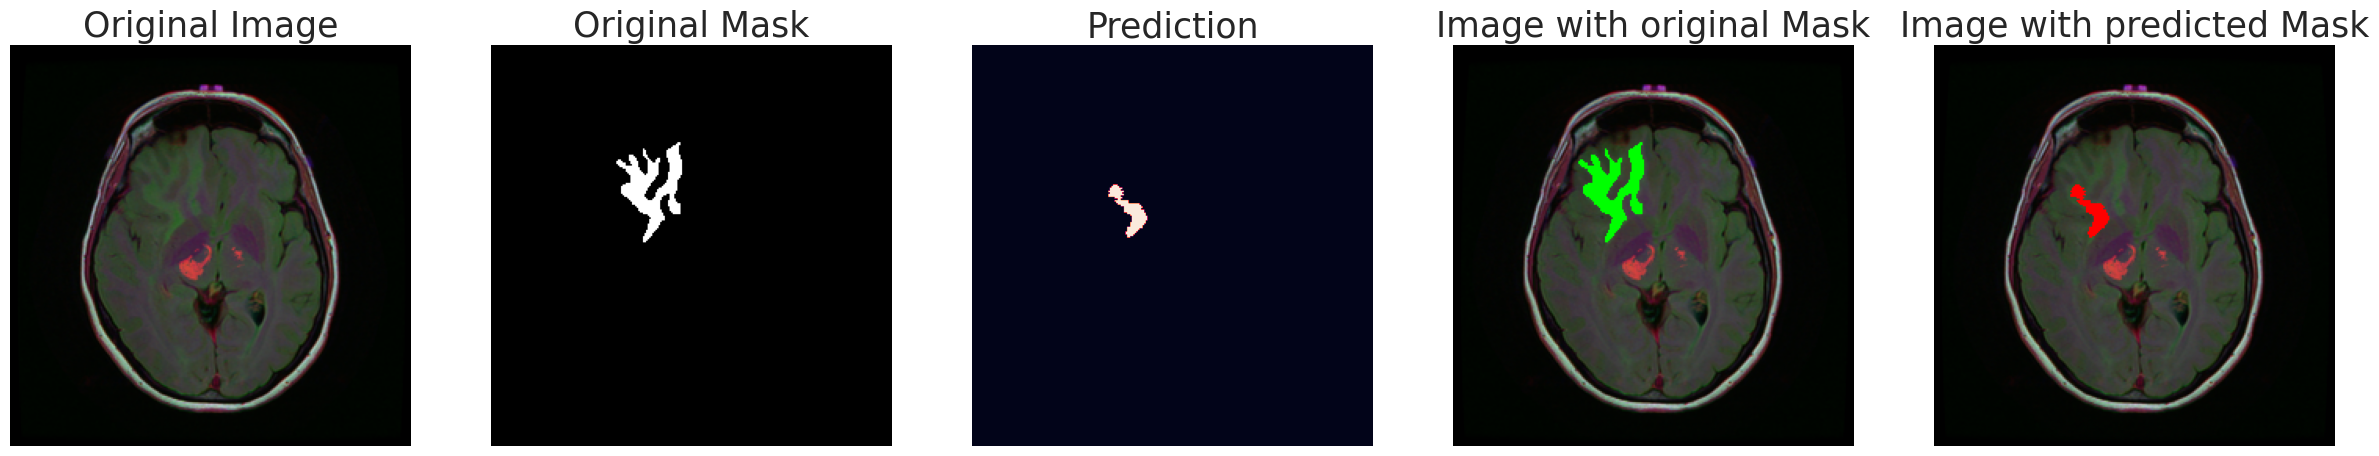

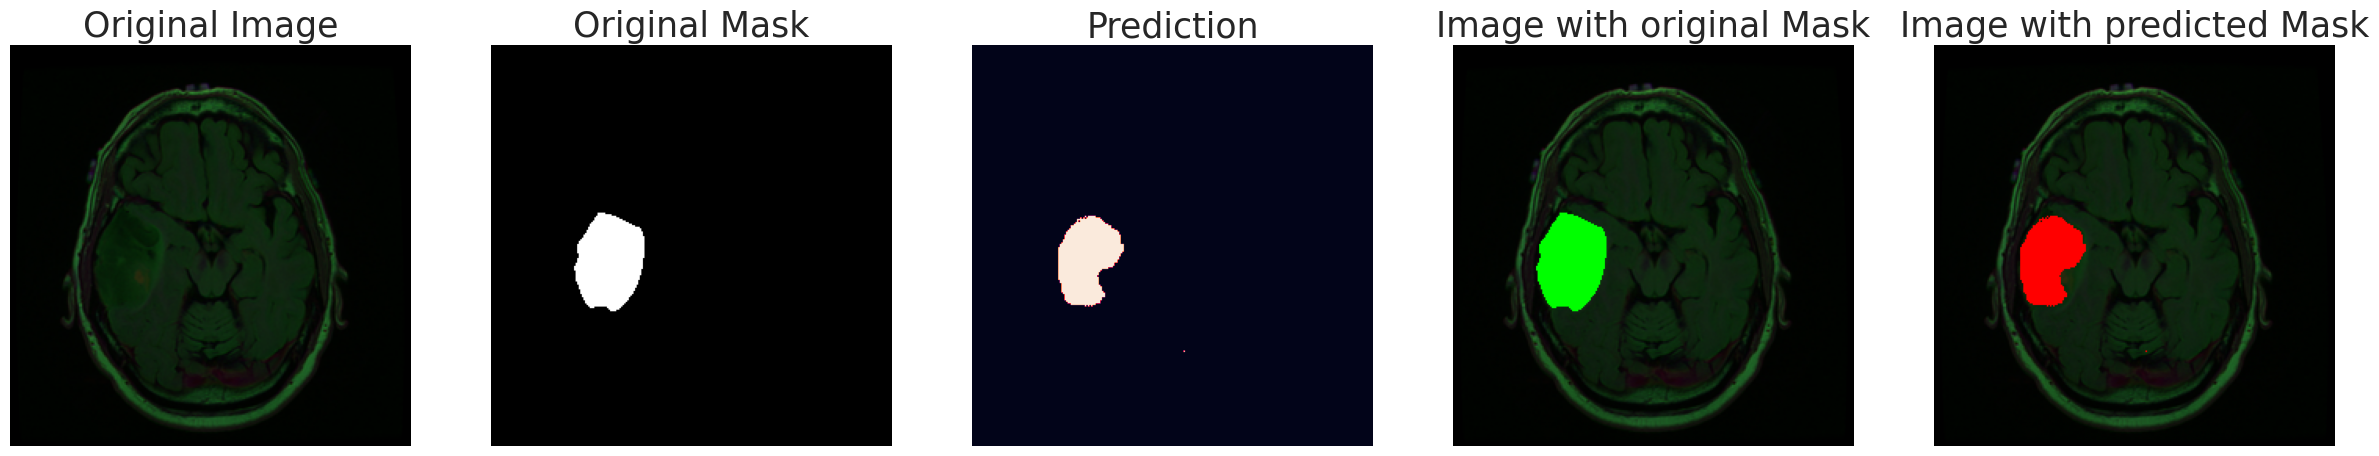

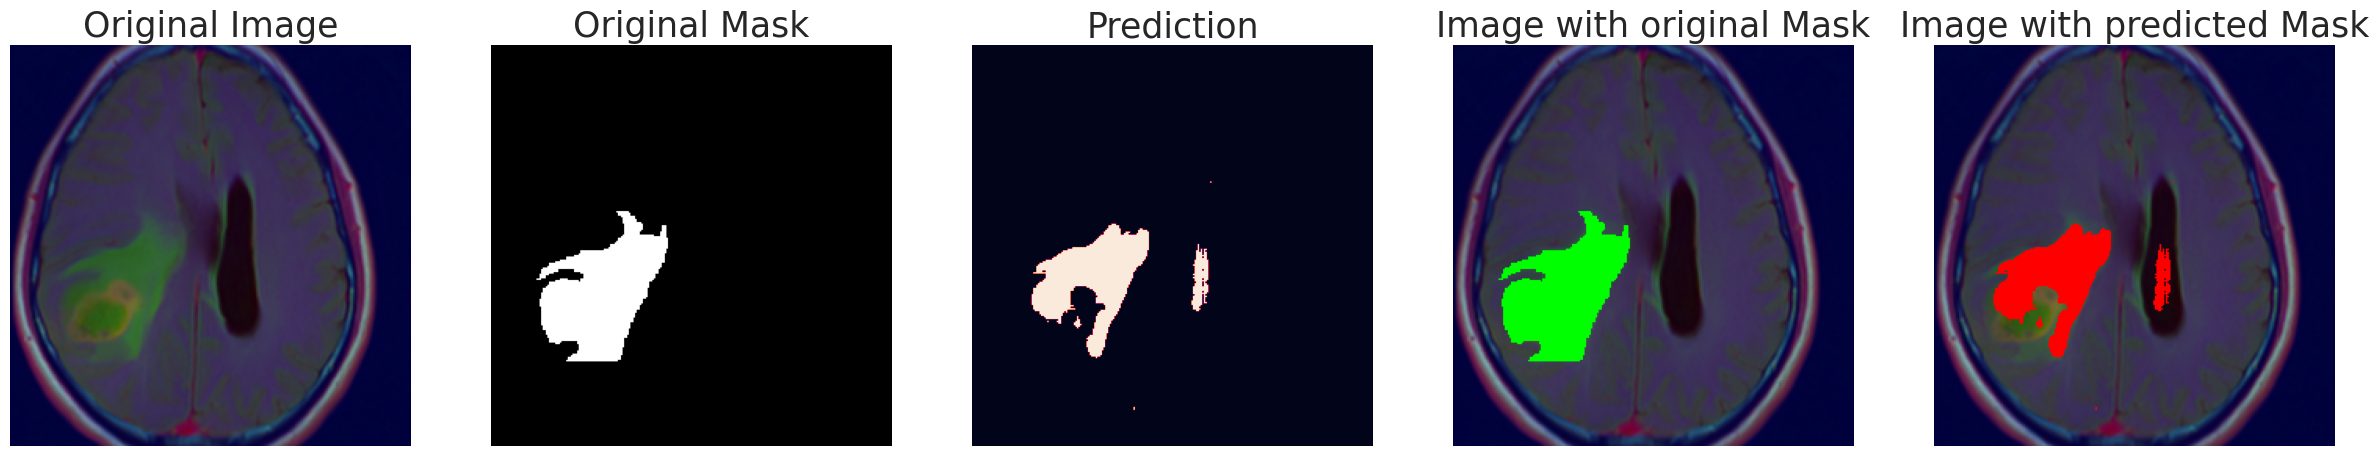

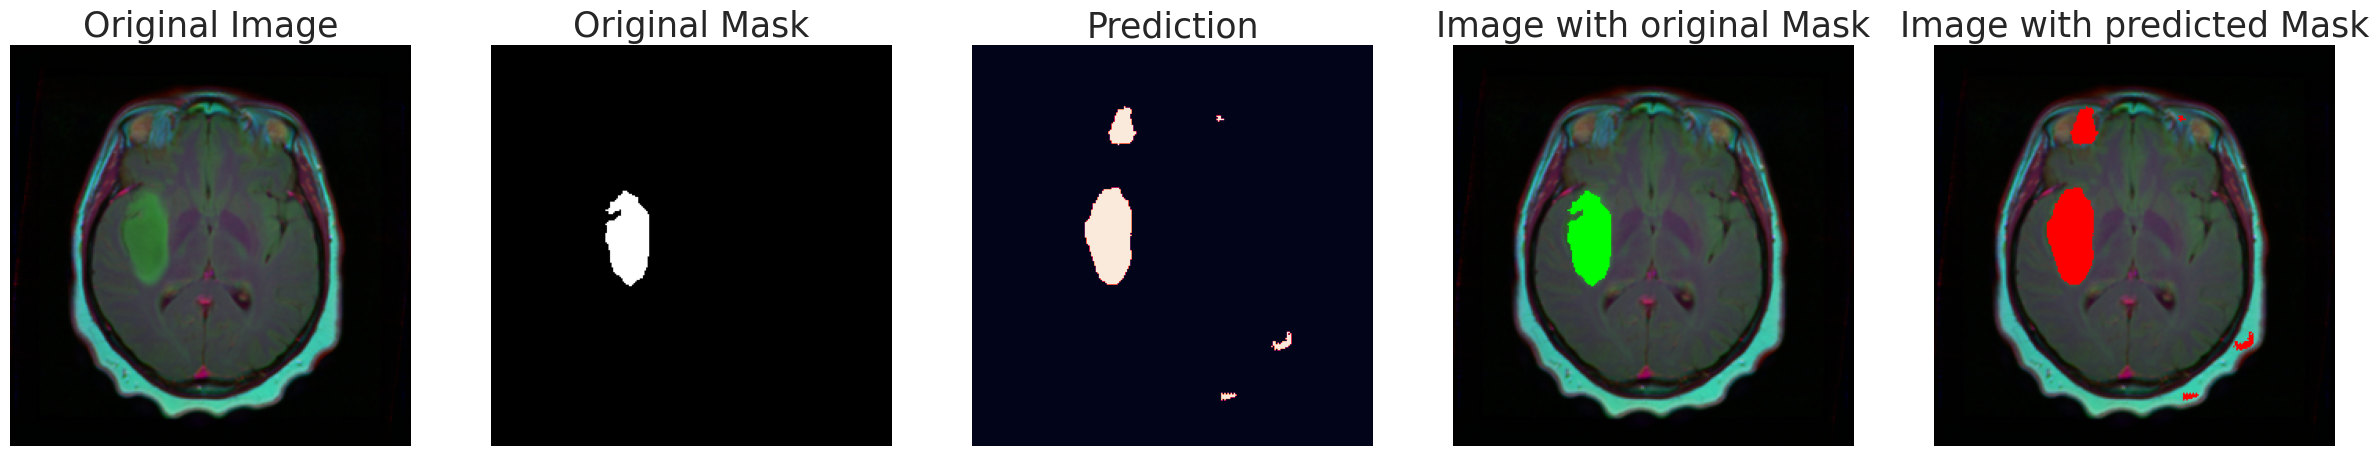

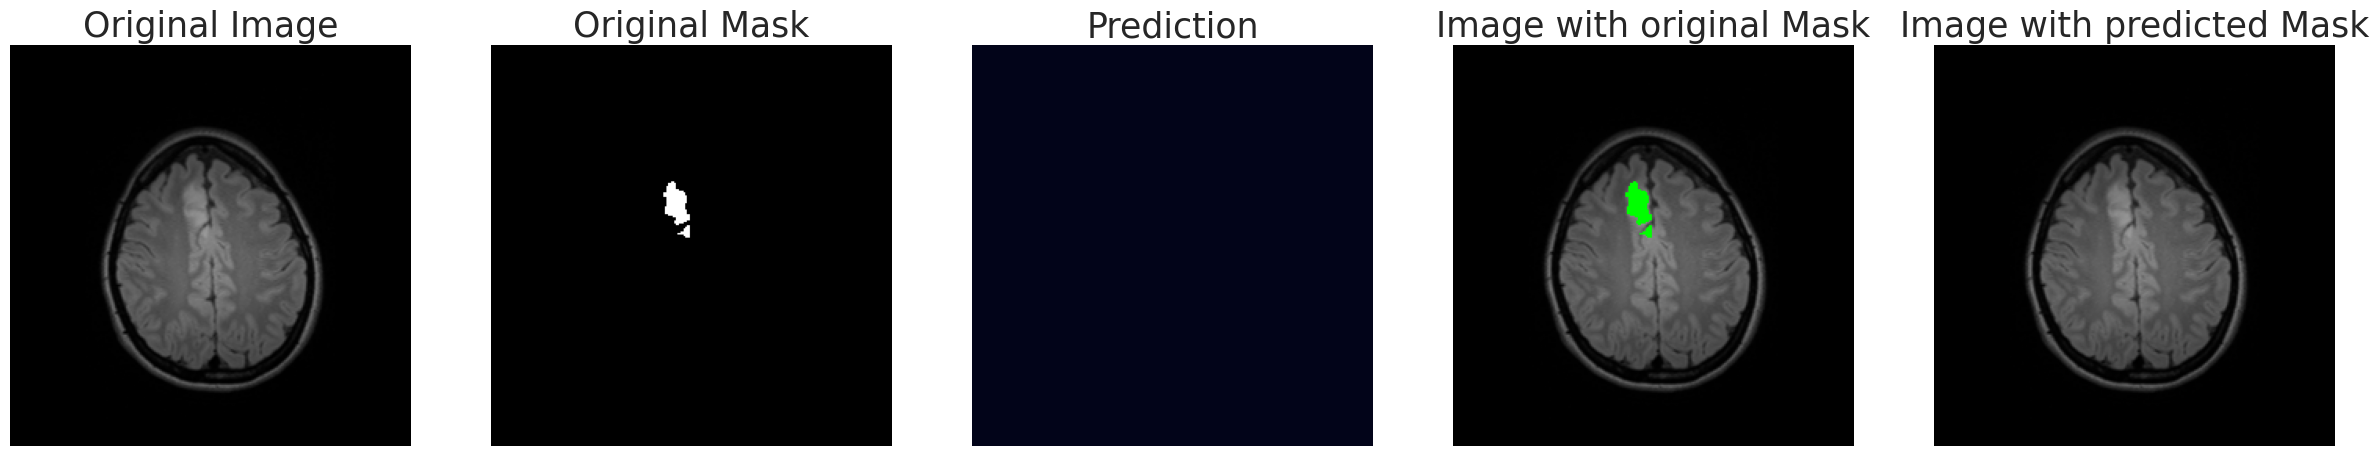

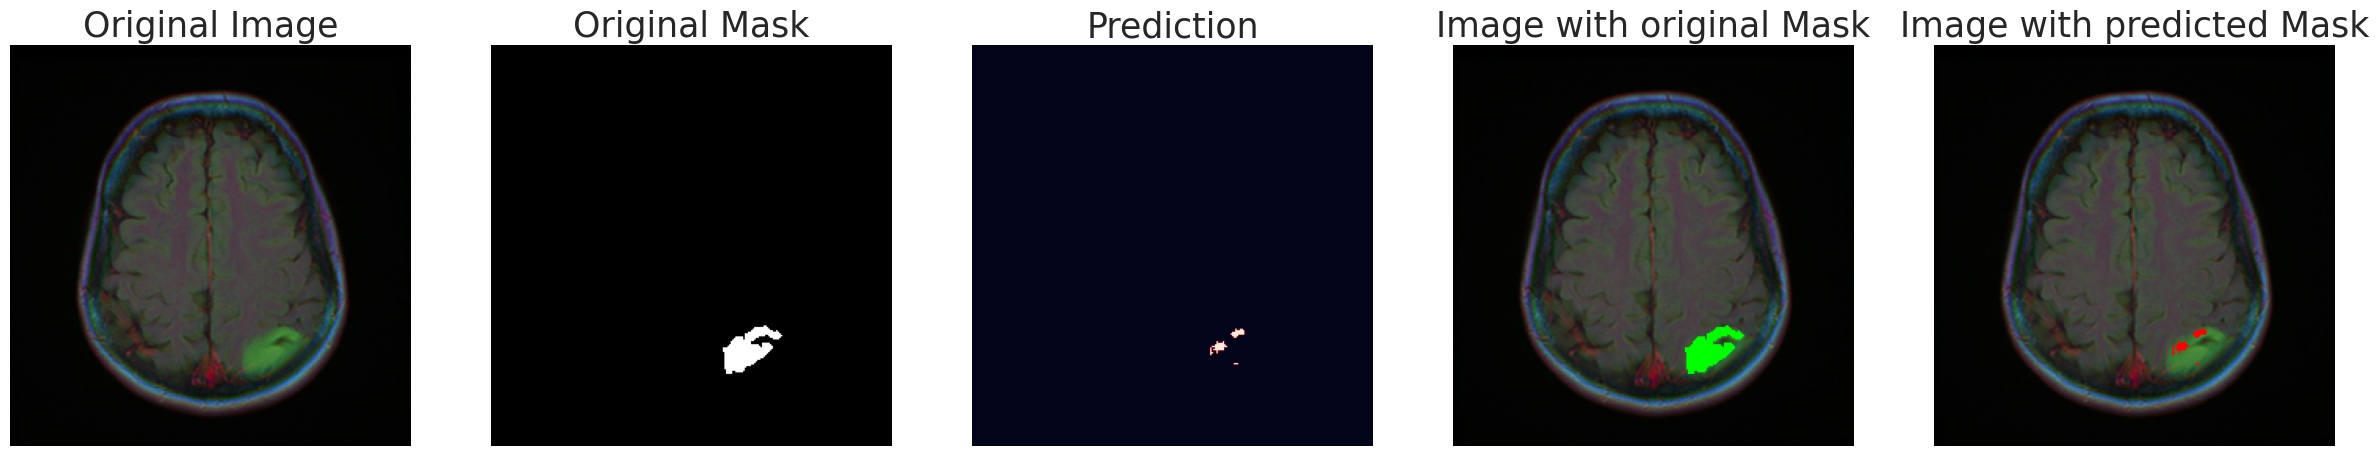

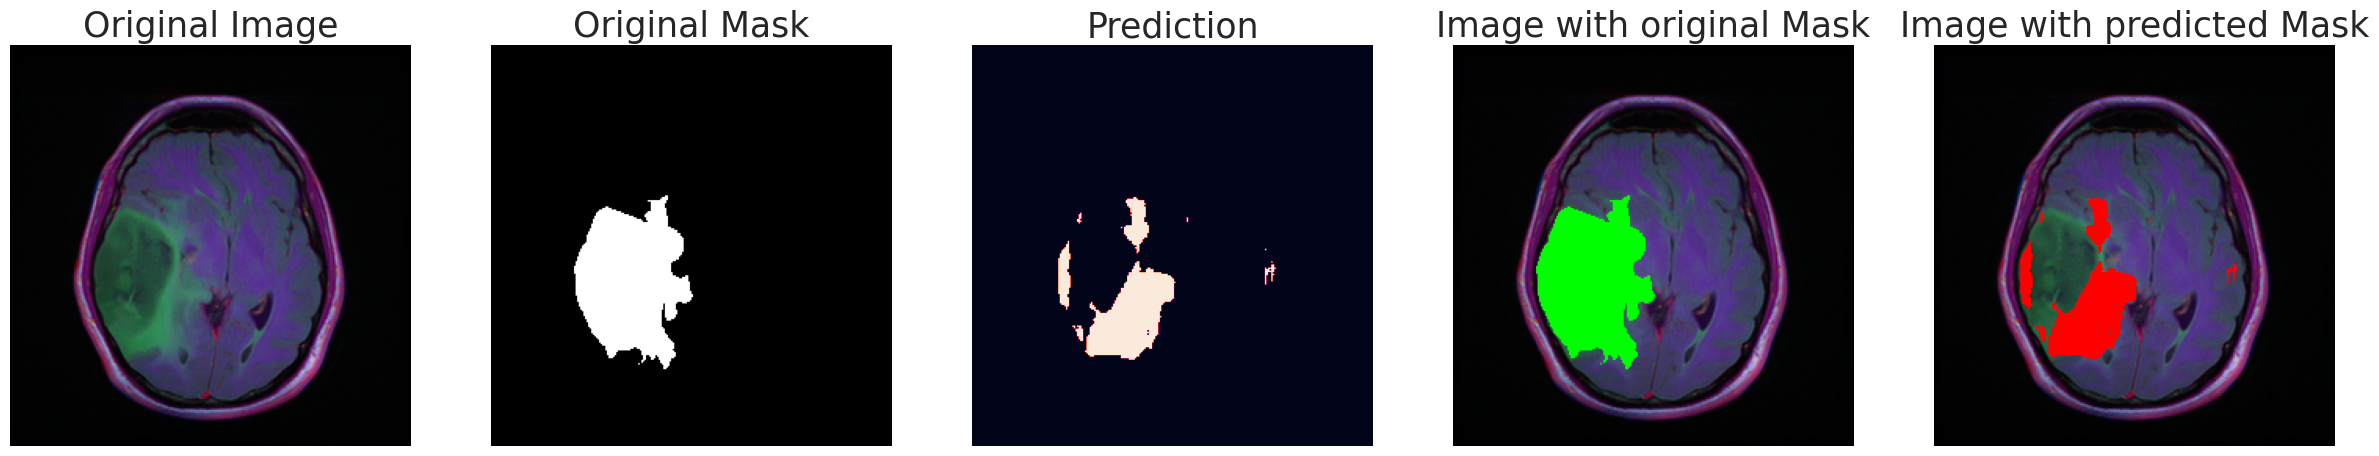

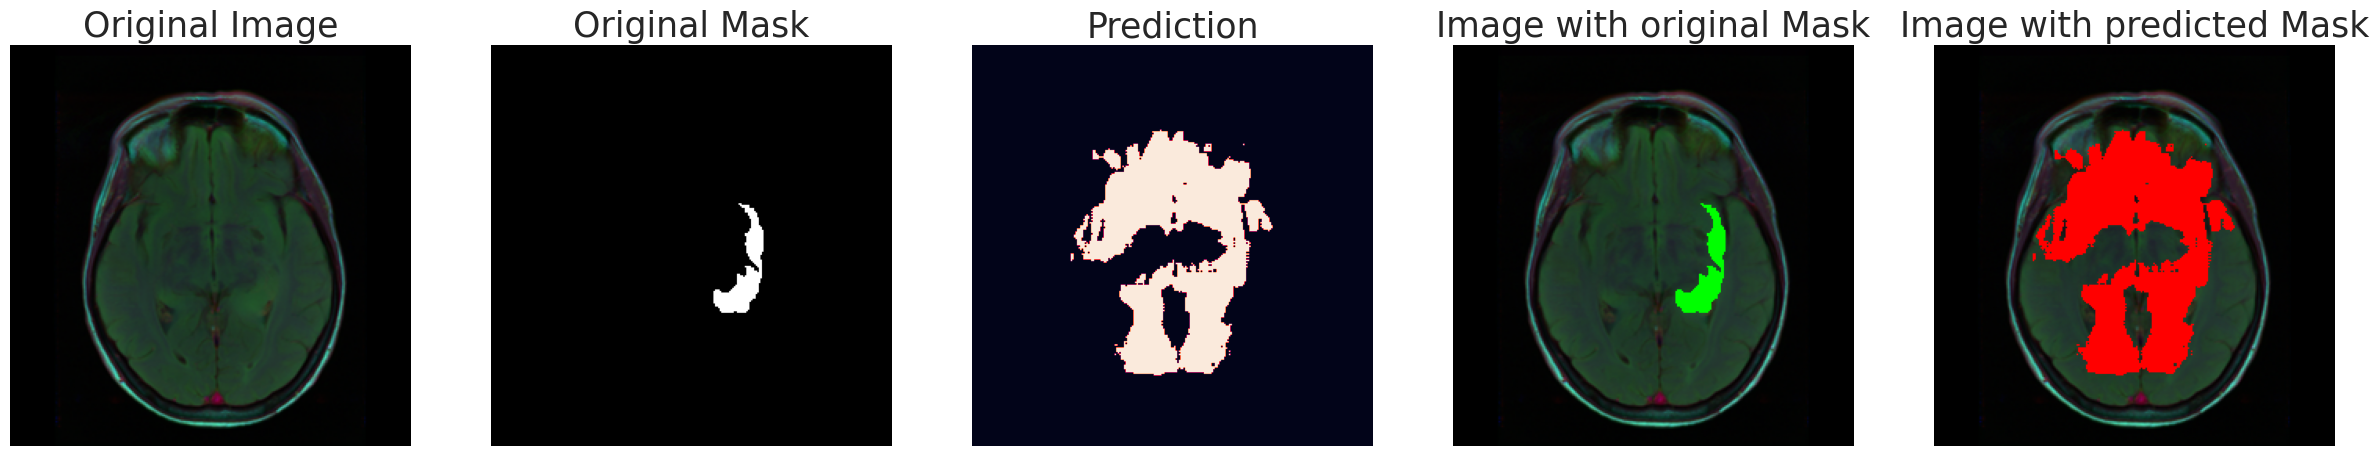

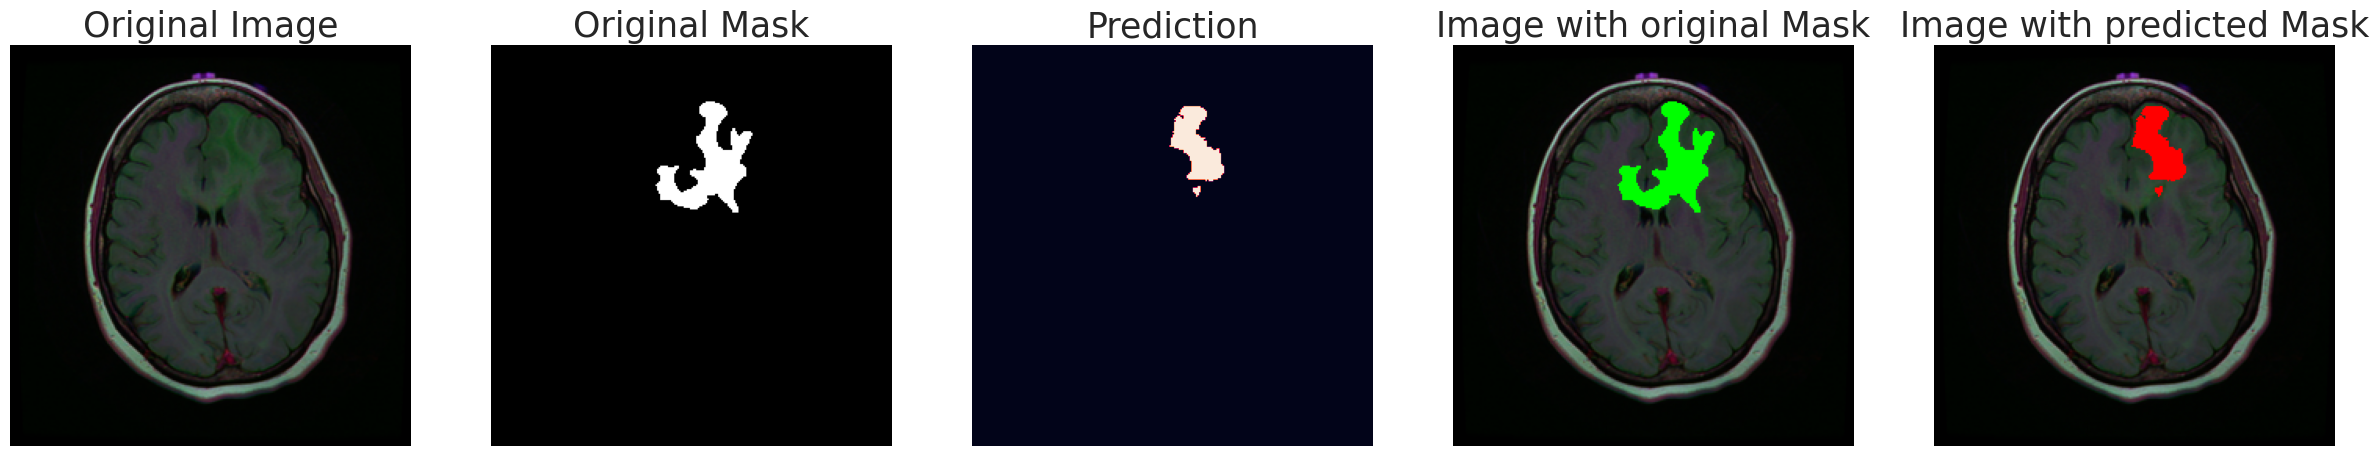

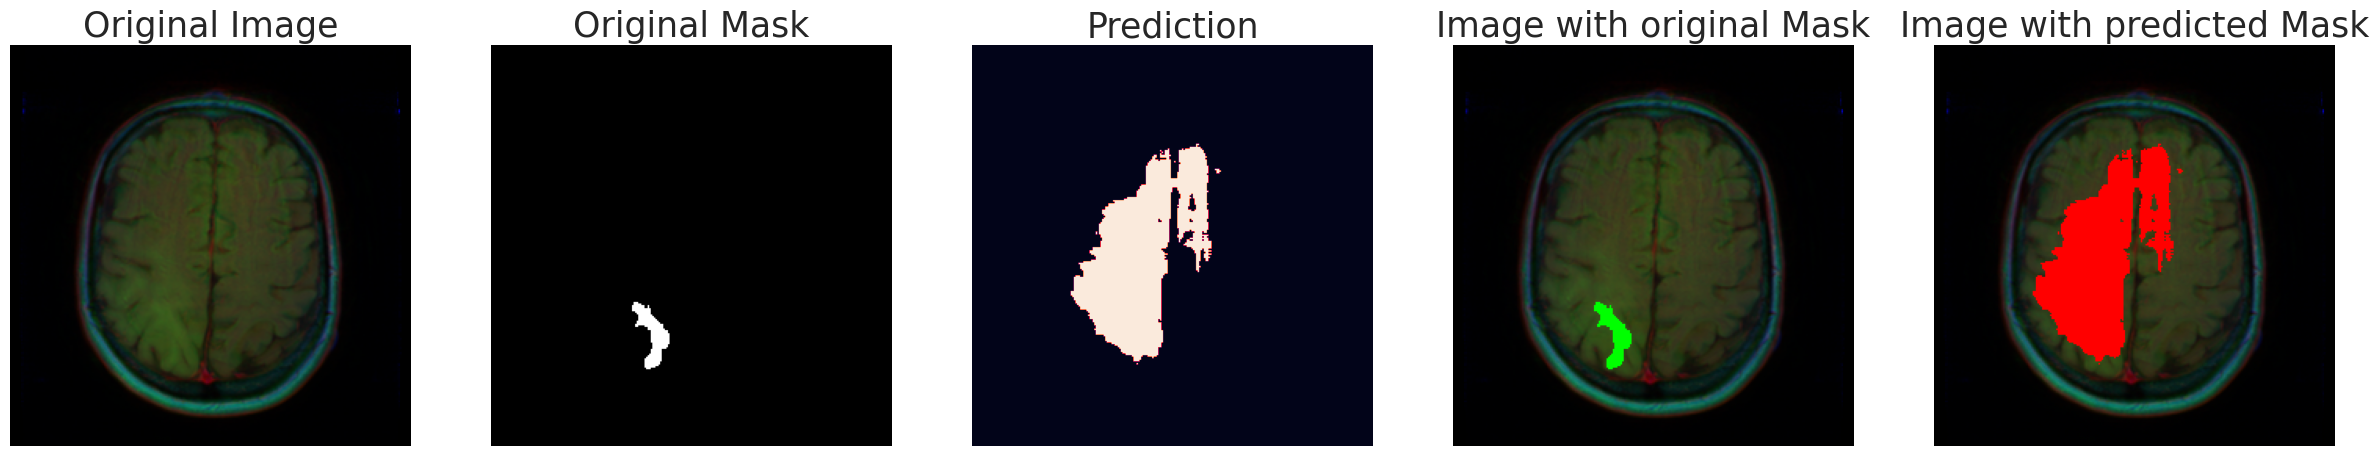

In [38]:
for _ in range(10):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img, verbose=0)

    plt.figure(figsize=(30, 70))
    
    plt.subplot(1, 5, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image',fontdict={'fontsize':25})

    plt.subplot(1, 5, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask',fontdict={'fontsize':25})

    plt.subplot(1, 5, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction',fontdict={'fontsize':25})
    plt.axis('off')
    
    img1= np.squeeze(img.copy())
    omask = cv2.imread(test_df['masks_paths'].iloc[index])
    omask = cv2.cvtColor(omask,cv2.COLOR_RGB2GRAY)
    img1[omask==255] = (0,255,0)
    plt.subplot(1, 5, 4)
    plt.imshow(img1)
    plt.title('Image with original Mask',fontdict={'fontsize':25})
    plt.axis('off')
    
    img2=np.squeeze(img.copy())
    predicted_img = np.squeeze(predicted_img)
    img2[predicted_img>0.5] = (255,0,0)    
    plt.subplot(1, 5, 5)
    plt.imshow(img2)
    plt.title('Image with predicted Mask',fontdict={'fontsize':25})
    plt.axis('off')
    
    plt.show
# plt.savefig( 'preds.jpg', dpi=800, bbox_inches = 'tight')